Notebook commun pour le projet


Groupe Emission:

In [73]:
import numpy as np 
import matplotlib.pyplot as plt
import numba as nb
import cython as cy
import scipy
import const


Retour point par point sur les différentes fonctions définies et vérification de leur cohérence:


Définition du paramètre $\Gamma$ avec les fonctions de Bessel et $\xi$

On a d'après l'équation (12):
$$ \Gamma = \frac{K_{3}(\xi)}{K_{2}(\xi)} - \frac{1}{\xi}    $$
Sachant que par analyse dimensionnelle $\xi$ est sans unité

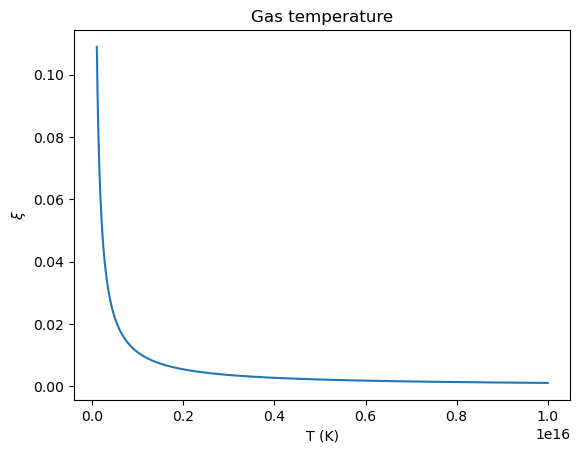

In [52]:
#Définition de Xi:
def xi(T):
    return (const.m_p*scipy.constants.c**2)/(const.k_b*T)

T = np.linspace(10**14,10**16,10000)
res = xi(T)
plt.plot(T,xi(T))
plt.title("Gas temperature")
plt.xlabel("T (K)")
plt.ylabel(r"$\xi $")
plt.show()



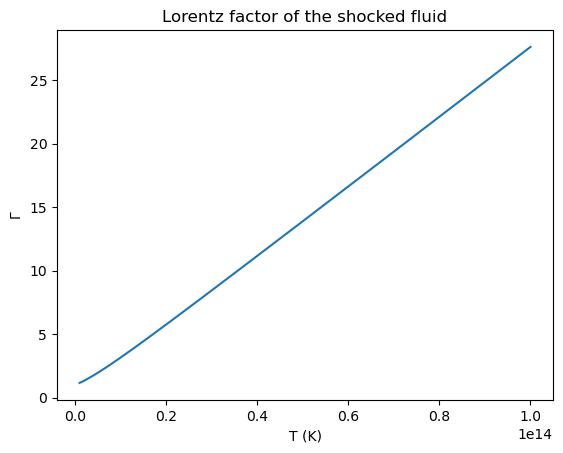

In [50]:
#Définition des fonctions de Bessel de première espèce (avec une limite finie en 0)
def K1(T) :
    return scipy.special.kn(1, xi(T))

def K2(x) :
    return scipy.special.kn(2, xi(T))

def K3(x) :
    return scipy.special.kn(3, xi(T))
def gamma_maj(T):
    return (K3(xi(T))/K2(xi(T)) - 1/xi(T))

plt.plot(T,gamma_maj(T))
plt.title("Lorentz factor of the shocked fluid")
plt.xlabel("T (K)")
plt.ylabel(r"$\Gamma $")
plt.show()



On définit maintenant la fonction $\hat{\gamma}'$:

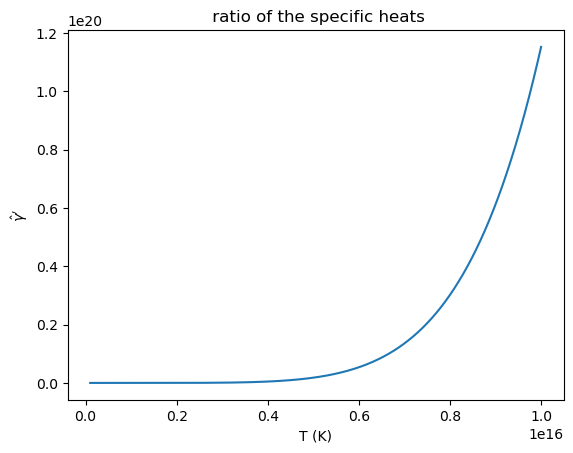

In [54]:
def gamma_chapeau_p(T):
    return (1 + 4*K2(xi(T))/xi(T)*(3*K3(xi(T) + K1(xi(T) - 4*K2(xi(T))))))
plt.plot(T,gamma_chapeau_p(T))
plt.title(" ratio of the specific heats")
plt.xlabel("T (K)")
plt.ylabel(r"$\hat{\gamma}' $")
plt.show()



Définition de la fonction $\frac{n'}{n_{0}}$:

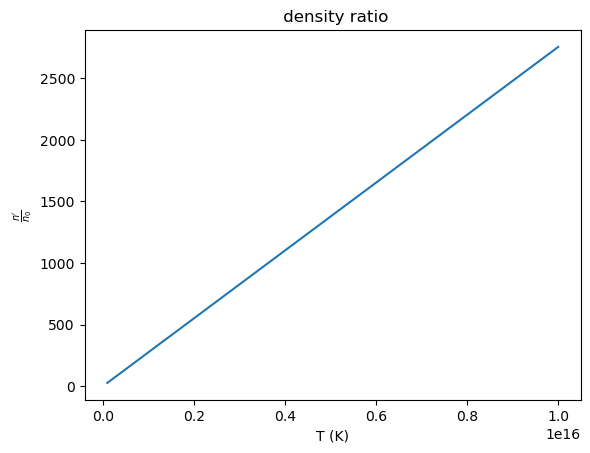

In [61]:
def n_prime(T):
    return ((gamma_chapeau_p(T)*gamma_maj(T) + 1)/gamma_chapeau_p(T) - 1)
plt.plot(T,n_prime(T))
plt.title(" density ratio")
plt.xlabel("T (K)")
plt.ylabel(r"$\frac{n'}{n_{0}} $")
plt.show()

Définition de la fonction $\frac{e_{i}}{n_{0}}'$ :

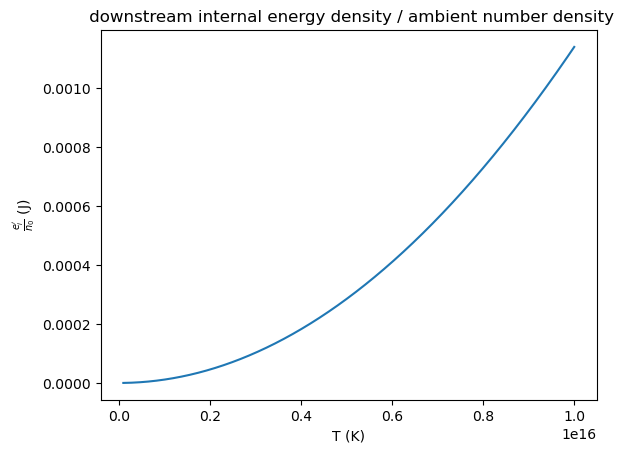

In [62]:
def e_i_p(T):
    return n_prime(T)*const.m_p*((scipy.constants.c)**2)*(gamma_maj(T)-1)

plt.plot(T,e_i_p(T))
plt.title(" downstream internal energy density / ambient number density")
plt.xlabel("T (K)")
plt.ylabel(r"$\frac{e_{i}'}{n_{0}}$ (J)")
plt.show()


Défintion de la fonction $\frac{P'}{n_{0}}$:

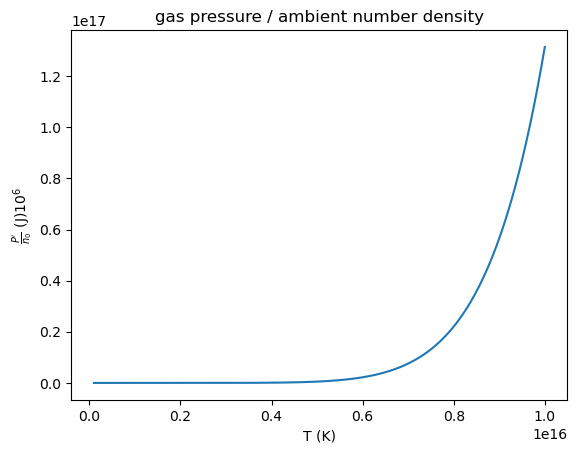

In [70]:
def P_prime(T):
    return (gamma_chapeau_p(T) - 1)*e_i_p(T)
plt.plot(T,P_prime(T))
plt.title("gas pressure / ambient number density")
plt.xlabel("T (K)")
plt.ylabel(r"$\frac{P'}{n_{0}}$ (J)$10^{6}$")
plt.show()

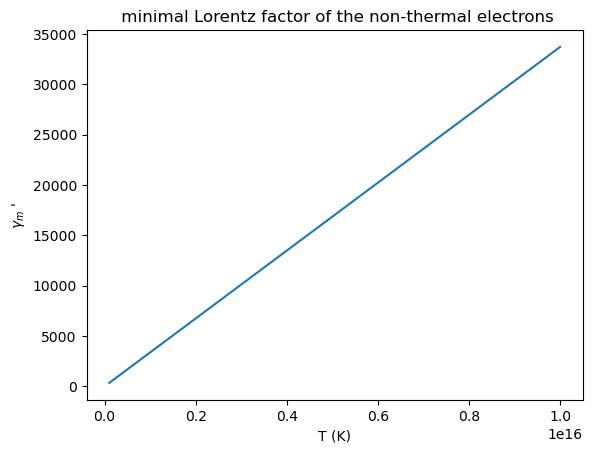

In [81]:
p =2.05
n0 = 1
t = 10
def gamma_prime_m(T,p):
    return np.maximum(1, (p - 2) / (p - 1) * const.m_p / const.m_e * 0.14 *(gamma_maj(T) -1))

plt.plot(T,gamma_prime_m(T,p))
plt.title(" minimal Lorentz factor of the non-thermal electrons")
plt.xlabel("T (K)")
plt.ylabel(r"$\gamma_{m}$ '")

plt.show()

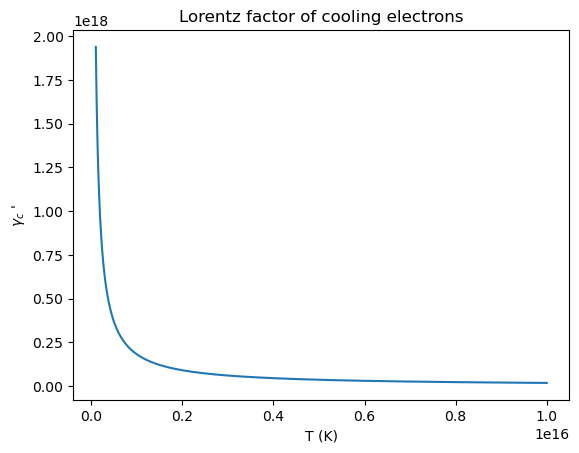

In [84]:
epsi_b = 4.12*(1/np.power(10,5))
def gamma_prime_c(n0,epsilon_B, T, t):
    return (3 * const.m_e * scipy.constants.c * gamma_maj(T)) / (4 * const.sigma_T * epsilon_B *e_i_p(T) * t*n0)
plt.plot(T,gamma_prime_c(n0,epsi_b_hollow_coneJ,T,t))
plt.title("Lorentz factor of cooling electrons")
plt.xlabel("T (K)")
plt.ylabel(r"$\gamma_{c}$ '")
plt.show()

Définition de la fonction B'(T):

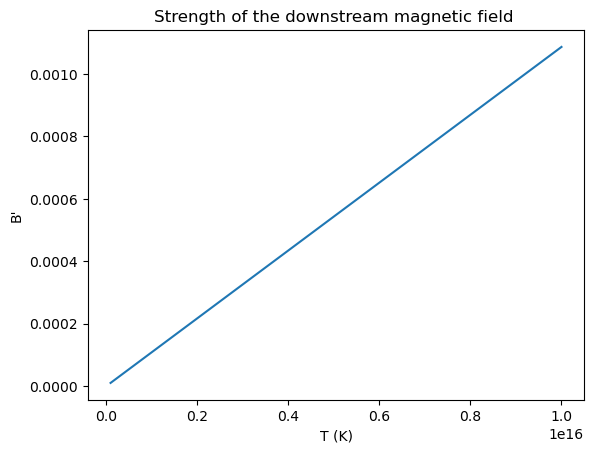

In [86]:
def B_prime(T,epsilon_B):
    return (np.sqrt(8*const.pi*epsilon_B*e_i_p(T)))

plt.plot(T,B_prime(T,epsi_b))
plt.title("Strength of the downstream magnetic field ")
plt.xlabel("T (K)")
plt.ylabel("B'")
plt.show()

In [89]:
def nu_prime_m(T,epsilon_B):
    return 3/16 * gamma_prime_m(T,p)**2 * const.q_e*B_prime(T,epsilon_B) / (const.m_e * scipy.const.c)

def nu_prime_c(n0,T,epsilon_B, t):
    return 3/16 * gamma_prime_c(n0,epsilon_B,T, t)**2 * const.q_e *B_prime(T,epsilon_B) / (const.m_e * scipy.const.c)
plt.plot(T,nu_prime_m(T,epsi_b))
plt.title("Strength of the downstream magnetic field ")
plt.xlabel("T (K)")
plt.ylabel("B'")
plt.show()
plt.plot(T,nu_prime_c(n0,T,epsi_b,t))
plt.title("Strength of the downstream magnetic field ")
plt.xlabel("T (K)")
plt.ylabel("B'")
plt.show()

AttributeError: module 'const' has no attribute 'c'

Pour la fonction d'émission qui est définie dans le papier par les équations (24) et (25) la renormalisation nous donne:

$$ x = \frac{\nu'}{\nu_{m}'}$$
Pour déterminer le régime de refroidissement on définit un rapport 
$$ \kappa = \frac{\nu_{c}'(\epsilon_{B},t)}{\nu_{m}'(\epsilon_{B})}$$
on obtient donc:
Si $\kappa > 1$:

 \[ $$ \frac{\epsilon_{\nu'}'}{\epsilon_{\nu', p}'} =$$
\begin{cases}
\text{$x^{\frac{1}{3}}$  pour  $x <1$} \\
\text{$x^{-(p-1)/2}$ pour  $1\leq x \leq \kappa$} \\
\text{$\kappa^{-1/2} x^{-p/2}$ pour  $\kappa < x$}
\end{cases}
\]

Si $\kappa \leq 1$:

 \[ $$ \frac{\epsilon_{\nu'}'}{\epsilon_{\nu', p}'} =$$
\begin{cases}
\text{$x^{\frac{1}{3}} \kappa^{-1/3}$  pour  $x <\kappa$} \\
\text{$\kappa^{1/2} x^{-1/2}$ pour  $\kappa\leq x < 1$} \\
\text{$\kappa^{-1/2} x^{-p/2}$ pour  $1  \leq x$}
\end{cases}
\]

In [4]:
#Pour la fonction d'émission on renormalise tout:
epsi_b_gaussianJ = 2.44*(1/np.power(10,4))
epsi_b_hollow_coneJ = 4.12*(1/np.power(10,5))
epsi_b_SpindleJ = 6.60*(1/np.power(10,4))
#pour l'instant en première approximation on prend p = 2.05


def power_I(x,y):
    return 1/np.power(x,y)

#Rapport de comparaison pour les refroidissemts entre nu_prim_c et nu_prim_m
def Kappa(epsilon_B,t):
    return nu_prime_c(epsilon_B,t)/nu_prime_m(epsilon_B)

#Cas du Fasct-cooling
def FastcEmission(x, Kappa,p,epsilon_B,t):
    if x > Kappa(epsilon_B,t):
        return np.power(Kappa(epsilon_B,t),-1/3)*np.power(x,1/3)
    elif x >= Kappa(epsilon_B,t) and x <1:
        return np.power(Kappa(epsilon_B,t),1/2)*power_I(x,-1/2)
    else:
        power_I(Kappa(epsilon_B,t),-1/2)*power_I(x,-p/2)
#Cas du slow-cooling
def SlowcEmission(x,Kappa,p,epsilon_B,t):
    if x < 1:
        return np.power(x,1/3)
    elif x>=1 and x < Kappa(epsilon_B,t):
        return power_I(x,-(p-1)/2)
    else:
        return power_I(Kappa(epsilon_B,t),-1/2)*power_I(-p/2)

#Vectorisation des fonctions liées aux régimes de refroidissement
SlowcEmission_vect = np.vectorize(lambda x: SlowcEmission(x,Kappa,p,epsi_b_gaussianJ,n0,t))
FastcEmission_vect = np.vectorize(lambda x: FastcEmission(x, Kappa,p,epsi_b_gaussianJ,n0,t))


#Fonction d'émission
def Emission_function(Kappa,x,p,epsilon_B,t):
    if Kappa(epsilon_B,t) > 1:
        return SlowcEmission_vect(x)
    else:
        return FastcEmission_vect(x)

    



In [5]:
x = np.linspace(0,10,5000)
y_H = Emission_function(Kappa,x,p,epsi_b_hollow_coneJ,t)
plt.plot(x,y_H)
plt.title("Emissivity function for hollow-cone jet")
plt.xlabel("x")
plt.ylabel("$\frac{\epsilon_{\nu'}'}{\epsilon_{\nu', p}'}")
plt.show()

NameError: name 'nu_prime_c' is not defined

Groupe équation 31